In [5]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
import random
from imblearn.under_sampling import RandomUnderSampler
import torch
import os
from catboost import CatBoostClassifier
def set_all_seeds(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.cuda.manual_seed_all(seed)
    pd.set_option('compute.use_numexpr', False)
    os.environ['TF_DETERMINISTIC_OPS'] = '1'
    os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

SEED = 42
set_all_seeds(SEED)

In [6]:
## UNDERSAMPLING
X_t = pd.read_parquet('X_t_tm_new.parquet')
y_t = pd.read_parquet('y_t_tm_new.parquet')['label']

# Remove users' NLP emotions
X_t = X_t.filter(regex='^(?!.*(std|avg|min|max)$)', axis=1)

undersample = RandomUnderSampler(sampling_strategy='majority', random_state=42)

# Split to train, test
X_train_t, X_test_t, y_train_t, y_test_t = train_test_split(X_t, y_t, test_size=0.2, random_state=42, stratify=y_t)
# Split to train, val
X_train_t, X_val_t, y_train_t, y_val_t = train_test_split(X_train_t, y_train_t, test_size=0.2, random_state=42, stratify=y_train_t)
# Undersample train
X_train_us_t, y_train_us_t = undersample.fit_resample(X_train_t, y_train_t)
X_val_us_t, y_val_us_t = undersample.fit_resample(X_val_t, y_val_t)
X_test_us_t, y_test_us_t = undersample.fit_resample(X_test_t, y_test_t)

# Count occurrences in each dataset
train_counts = y_train_us_t.value_counts()
val_counts = y_val_us_t.value_counts()
test_counts = y_test_us_t.value_counts()
test_counts_imbalanced = y_test_t.value_counts()

print("Train set class counts:\n", train_counts, "\n")
print("Validation set class counts:\n", val_counts, "\n")
print("Test set class counts:\n", test_counts, "\n")
print("imbalanced test set class counts:\n", test_counts_imbalanced, "\n")


Train set class counts:
 label
0    9606
1    9606
Name: count, dtype: int64 

Validation set class counts:
 label
0    2401
1    2401
Name: count, dtype: int64 

Test set class counts:
 label
0    3002
1    3002
Name: count, dtype: int64 

imbalanced test set class counts:
 label
0    61211
1     3002
Name: count, dtype: int64 



In [10]:
def save_catboost_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    # Load the saved model
    model_cat_u_best_loaded = CatBoostClassifier(random_state=42)
    model_cat_u_best_loaded.load_model(model_file_path)

    # Define feature names (ensure X_test has the columns defined)
    feature_names = X_test.columns

    # Retrieve and sort feature importance
    feature_importance = model_cat_u_best_loaded.get_feature_importance()
    feature_importance_map = dict(zip(feature_names, feature_importance))
    sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

    # Predict with the loaded model
    y_pred = model_cat_u_best_loaded.predict(X_test)
    y_pred_b = model_cat_u_best_loaded.predict(X_test_b)

    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)

    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_cat_u_best_loaded.get_params()
        f.write("\nHyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification report
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
    
        # Write feature importance
        f.write("Feature Importance from the Loaded Model:\n")
        for feature_name, importance in sorted_importance:
            f.write(f"{feature_name}: {importance}\n")


def save_lgbm_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    import joblib
    # Load the saved model
    model_lgb_loaded = joblib.load(model_file_path)

    # Define feature names (ensure X_test has the columns defined)
    feature_names = X_test.columns

    # Retrieve and sort feature importance
    feature_importance = model_lgb_loaded.feature_importances_
    feature_importance_map = dict(zip(feature_names, feature_importance))
    sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

    print("Top 20 Feature Importance:")
    for feature_name, importance in sorted_importance:
        print(f"{feature_name}: {importance}")

    # Predict with the loaded model
    y_pred = model_lgb_loaded.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  
    
    y_pred_b = model_lgb_loaded.predict(X_test_b)
    y_pred_b = (y_pred_b > 0.5).astype(int)  

    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)

    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_lgb_loaded.get_params()
        f.write("Hyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification report
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
        
        # Write feature importance
        f.write("Feature Importance from the Loaded Model:\n")
        for feature_name, importance in sorted_importance:
            f.write(f"{feature_name}: {importance}\n")
        
def save_nn_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    import joblib
    import shap
    from sklearn.metrics import classification_report
    
    # Load the saved model
    model_nn_best_loaded = joblib.load(model_file_path)
    
    # Predict with the loaded model
    y_pred = model_nn_best_loaded.predict(X_test)
    y_pred_b = model_nn_best_loaded.predict(X_test_b)
    
    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)
    
    
    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_nn_best_loaded.get_params()
        f.write("Hyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification report
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
    

        
def save_xgb_evaluation_results(model_file_path, X_test, y_test, X_test_b, y_test_b, output_file_path):
    import joblib
    from sklearn.metrics import classification_report
    
    # Load the saved model
    model_xgb_loaded = joblib.load(model_file_path)

    # Define feature names (ensure X_test has the columns defined)
    feature_names = X_test.columns

    # Retrieve and sort feature importance
    feature_importance = model_xgb_loaded.feature_importances_
    feature_importance_map = dict(zip(feature_names, feature_importance))
    sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

    print("Top 20 Feature Importance:")
    for feature_name, importance in sorted_importance[:20]:  # Print only the top 20
        print(f"{feature_name}: {importance}")

    # Predict with the loaded model
    y_pred = model_xgb_loaded.predict(X_test)
    y_pred = (y_pred > 0.5).astype(int)  # Threshold for binary classification
    
    y_pred_b = model_xgb_loaded.predict(X_test_b)
    y_pred_b = (y_pred_b > 0.5).astype(int)  # Threshold for binary classification

    # Compute the classification report
    report = classification_report(y_test, y_pred, digits=4)
    report_b = classification_report(y_test_b, y_pred_b, digits=4)

    # Write results to the file
    with open(output_file_path, 'w') as f:
        # Get hyperparameters
        params = model_xgb_loaded.get_params()
        f.write("Hyperparameters:\n")
        for key, value in params.items():
            f.write(f"{key}: {value}\n")
    
        # Write classification reports
        f.write("\nClassification Report:\n")
        f.write(f"{report}\n")
        f.write("\nClassification Report:\n")
        f.write(f"{report_b}\n")
        
        # Write feature importance
        f.write("\nFeature Importance from the Loaded Model:\n")
        for feature_name, importance in sorted_importance[:20]:  # Write only the top 20
            f.write(f"{feature_name}: {importance}\n")



In [4]:
# Model CATBOOST
import optuna
from catboost import CatBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, classification_report
from tqdm import tqdm

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "depth": trial.suggest_int("depth", 4, 12),  # Depth of the trees
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),  # Learning rate
        "l2_leaf_reg": trial.suggest_float("l2_leaf_reg", 1e-5, 10, log=True),  # L2 regularization term
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 50),  # Minimum number of data points in a leaf
        "max_bin": trial.suggest_int("max_bin", 128, 256),
        "grow_policy": trial.suggest_categorical("grow_policy", ["SymmetricTree", "Depthwise", "Lossguide"]),  # Tree growing policy
        "iterations": trial.suggest_int("iterations", 100, 1000),  # Number of boosting iterations (trees)
    }
    # Initialize and train the model
    model = CatBoostClassifier(**params, random_seed=42, task_type="GPU", devices="0", verbose=0)
    model.fit(X_train_us_t, y_train_us_t, eval_set=(X_val_us_t, y_val_us_t), early_stopping_rounds=50, verbose=0)

    # Predict and evaluate
    y_pred = model.predict(X_test_t)
    f1_macro = f1_score(y_test_t, y_pred, average='macro')
    
    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler(seed=42))
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train final model with the best parameters
model_cat_t_best = CatBoostClassifier(**best_params, random_seed=42, task_type="GPU", devices="0", verbose=0)
model_cat_t_best.fit(X_train_us_t, y_train_us_t)

# Predict and evaluate with the best model
y_pred_cat_t_best = model_cat_t_best.predict(X_test_t)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_t, y_pred_cat_t_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_t, y_pred_cat_t_best, digits=4))
# Define feature names
feature_names_t = X_train_us_t.columns
# Feature importance
feature_importance_cat_t_best = model_cat_t_best.get_feature_importance()
feature_importance_map_t_best = dict(zip(feature_names_t, feature_importance_cat_t_best))
sorted_importance_cat_t_best = sorted(feature_importance_map_t_best.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Feature Importance:")
for feature_name, importance in sorted_importance_cat_t_best:
    print(f"{feature_name}: {importance}")
    
model_cat_t_best.save_model('models/catboost_t_tm_new.cbm')
save_catboost_evaluation_results('models/catboost_t_tm_new.cbm', X_test_t, y_test_t, X_test_us_t, y_test_us_t, 'models/catboost_t_tm_new.txt')


[I 2024-08-31 15:54:42,245] A new study created in memory with name: no-name-8257d8da-0718-44c7-96c9-ef24d97293dd


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-08-31 15:54:45,667] Trial 0 finished with value: 0.5173759962233175 and parameters: {'depth': 7, 'learning_rate': 0.22648248189516848, 'l2_leaf_reg': 0.24658329458549094, 'min_data_in_leaf': 34, 'max_bin': 148, 'grow_policy': 'Lossguide', 'iterations': 641}. Best is trial 0 with value: 0.5173759962233175.
[I 2024-08-31 15:55:05,871] Trial 1 finished with value: 0.519746182401548 and parameters: {'depth': 10, 'learning_rate': 0.001124579825911934, 'l2_leaf_reg': 6.598711072054068, 'min_data_in_leaf': 44, 'max_bin': 155, 'grow_policy': 'Lossguide', 'iterations': 572}. Best is trial 1 with value: 0.519746182401548.
[I 2024-08-31 15:55:14,715] Trial 2 finished with value: 0.5211933716785235 and parameters: {'depth': 7, 'learning_rate': 0.005265139631677754, 'l2_leaf_reg': 0.046894009635376835, 'min_data_in_leaf': 15, 'max_bin': 165, 'grow_policy': 'Lossguide', 'iterations': 279}. Best is trial 2 with value: 0.5211933716785235.
[I 2024-08-31 15:55:31,319] Trial 3 finished with value

In [5]:
#LGBM
import os
import optuna


# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'
# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "objective": "binary",
        "metric": "binary_error",
        "num_leaves": trial.suggest_int("num_leaves", 31, 255),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.3, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.1, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.1, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "lambda_l1": trial.suggest_float("lambda_l1", 0.0, 10.0),
        "lambda_l2": trial.suggest_float("lambda_l2", 0.0, 10.0),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
        "max_depth": trial.suggest_int("max_depth", -1, 50),  # -1 means no limit
        "min_child_weight": trial.suggest_float("min_child_weight", 0.0, 10.0),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
        "subsample_for_bin": trial.suggest_int("subsample_for_bin", 200000, 300000),
        "cat_smooth": trial.suggest_float("cat_smooth", 1.0, 20.0),
        "num_boost_round": trial.suggest_int("num_boost_round", 100, 1000),
        "num_threads": -1
    }
    
    # Initialize and train the model
    model = lgb.LGBMClassifier(**params)
    model.fit(X_train_us_t, y_train_us_t,
              eval_set=[(X_val_us_t, y_val_us_t)],
              eval_metric='binary_error')

    # Predict and evaluate
    y_pred = model.predict(X_test_t)
    f1_macro = f1_score(y_test_t, y_pred, average='macro')
    
    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train final model with the best parameters
model_lgb_best = lgb.LGBMClassifier(**best_params)
model_lgb_best.fit(X_train_us_t, y_train_us_t)

# Predict and evaluate with the best model
y_pred_lgb_best = model_lgb_best.predict(X_test_t)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_t, y_pred_lgb_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_t, y_pred_lgb_best, digits=4))

# Define feature names
feature_names_t = X_train_us_t.columns
# Feature importance
feature_importance_lgb_best = model_lgb_best.feature_importances_
feature_importance_map_lgb_best = dict(zip(feature_names_t, feature_importance_lgb_best))
sorted_importance_lgb_best = sorted(feature_importance_map_lgb_best.items(), key=lambda x: x[1], reverse=True)[:20]

print("Top 20 Feature Importance:")
for feature_name, importance in sorted_importance_lgb_best:
    print(f"{feature_name}: {importance}")

# Save the model
import joblib

joblib.dump(model_lgb_best, 'models/lightgbm_t_tm_new.joblib')
save_lgbm_evaluation_results('models/lightgbm_t_tm_new.joblib', X_test_t, y_test_t, X_test_us_t, y_test_us_t, 'models/lightgbm_t_tm_new.txt')


[I 2024-08-31 16:12:02,956] A new study created in memory with name: no-name-cf17d412-93b2-4e59-bdb5-905bc8f857e8


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4567745382966403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4567745382966403
[LightGBM] [Warning] lambda_l1 is set=2.2017457494014314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.2017457494014314
[LightGBM] [Warning] lambda_l2 is set=0.9413314943307038, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.9413314943307038
[LightGBM] [Warning] bagging_fraction is set=0.9027096135637378, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9027096135637378
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] num_iterations is set=490, num_boost_round=490 will be ignored. Current value: num_iterations=490
[LightGBM] [Warning] feature_fraction is set=0.4567745382966403, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4567745382966403
[LightGBM] [Warning] lambda_l1 is set=2.20174574940

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.019834 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212, number of used features: 90
[LightGBM] [Warning] feature_fraction is set=0.899983138521541, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.899983138521541
[LightGBM] [Warning] lambda_l1 is set=0.14652596685244879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.14652596685244879
[LightGBM] [Warning] lambda_l2 is set=2.673961611504616, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.673961611504616
[LightGBM] [Warning] bagging_fraction is set=0.17808559345948172, subsample=1.0 will be ignored. Current value: bagging_fraction=0.17808559345948172
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Warning] num_iteratio

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8934631834925435, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8934631834925435
[LightGBM] [Warning] lambda_l1 is set=4.791532539932016, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.791532539932016
[LightGBM] [Warning] lambda_l2 is set=5.928521882758756, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.928521882758756
[LightGBM] [Warning] bagging_fraction is set=0.6742120215930588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6742120215930588
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[I 2024-08-31 16:12:43,151] Trial 5 finished with value: 0.39949774364411844 and parameters: {'num_leaves': 62, 'learning_rate': 0.0012971113001314905, 'feature_fraction': 0.8934631834925435, 'bagging_fraction': 0.6742120215930588, 'bagging_freq': 5, 'lambda_l1': 4.791532539932016, 'lambda_l2': 5.928521882758756, 'min_child_sa

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.3450122086834049, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3450122086834049
[LightGBM] [Warning] lambda_l1 is set=1.5798630932219015, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.5798630932219015
[LightGBM] [Warning] lambda_l2 is set=0.824664529594964, reg_lambda=0.0 will be ignored. Current value: lambda_l2=0.824664529594964
[LightGBM] [Warning] bagging_fraction is set=0.22186001410511164, subsample=1.0 will be ignored. Current value: bagging_fraction=0.22186001410511164
[LightGBM] [Warning] bagging_freq is set=8, subsample_freq=0 will be ignored. Current value: bagging_freq=8
[LightGBM] [Warning] num_iterations is set=194, num_boost_round=194 will be ignored. Current value: num_iterations=194
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4918216210822123, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4918216210822123
[LightGBM] [Warning] lambda_l1 is set=3.1947736377895577, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1947736377895577
[LightGBM] [Warning] lambda_l2 is set=5.581418062352315, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.581418062352315
[LightGBM] [Warning] bagging_fraction is set=0.21855143736542404, subsample=1.0 will be ignored. Current value: bagging_fraction=0.21855143736542404
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Warning] num_iterations is set=862, num_boost_round=862 will be ignored. Current value: num_iterations=862
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008060 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212, number of used features: 90
[LightGBM] [Warning] feature_fraction is set=0.8197371746752152, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8197371746752152
[LightGBM] [Warning] lambda_l1 is set=2.787523206737413, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.787523206737413
[LightGBM] [Warning] lambda_l2 is set=6.909506411923578, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.909506411923578
[LightGBM] [Warning] bagging_fraction is set=0.35058162932346126, subsample=1.0 will be ignored. Current value: bagging_fraction=0.35058162932346126
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] num_iterations i

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.19736797920309884, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.19736797920309884
[LightGBM] [Warning] lambda_l1 is set=6.9978179307788215, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.9978179307788215
[LightGBM] [Warning] lambda_l2 is set=4.395055772340614, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.395055772340614
[LightGBM] [Warning] bagging_fraction is set=0.6445447834017319, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6445447834017319
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011459 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 1

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.15466011450598444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15466011450598444
[LightGBM] [Warning] lambda_l1 is set=7.686764649046331, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.686764649046331
[LightGBM] [Warning] lambda_l2 is set=4.337397161683919, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.337397161683919
[LightGBM] [Warning] bagging_fraction is set=0.6485058440029725, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6485058440029725
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008173 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.15100224151282216, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.15100224151282216
[LightGBM] [Warning] lambda_l1 is set=7.71836469537428, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.71836469537428
[LightGBM] [Warning] lambda_l2 is set=3.729658603087238, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.729658603087238
[LightGBM] [Warning] bagging_fraction is set=0.7507322716948883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7507322716948883
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006930 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9205
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2982955668546532, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2982955668546532
[LightGBM] [Warning] lambda_l1 is set=4.733235914660002, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.733235914660002
[LightGBM] [Warning] lambda_l2 is set=5.498429288791175, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.498429288791175
[LightGBM] [Warning] bagging_fraction is set=0.47915462029526357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47915462029526357
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005182 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7342272735159867, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7342272735159867
[LightGBM] [Warning] lambda_l1 is set=3.932279517680949, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.932279517680949
[LightGBM] [Warning] lambda_l2 is set=6.388601038561717, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.388601038561717
[LightGBM] [Warning] bagging_fraction is set=0.3502536659495633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.3502536659495633
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.022817 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.34234481319236665, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.34234481319236665
[LightGBM] [Warning] lambda_l1 is set=9.940348671390272, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.940348671390272
[LightGBM] [Warning] lambda_l2 is set=3.737037493707516, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.737037493707516
[LightGBM] [Warning] bagging_fraction is set=0.7983505087553588, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7983505087553588
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003337 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6752295378259061, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6752295378259061
[LightGBM] [Warning] lambda_l1 is set=6.252530880540864, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.252530880540864
[LightGBM] [Warning] lambda_l2 is set=7.478389280661545, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.478389280661545
[LightGBM] [Warning] bagging_fraction is set=0.6113340332753363, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6113340332753363
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013518 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.10386799916648404, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10386799916648404
[LightGBM] [Warning] lambda_l1 is set=8.220665473593899, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.220665473593899
[LightGBM] [Warning] lambda_l2 is set=4.991560089319427, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.991560089319427
[LightGBM] [Warning] bagging_fraction is set=0.2793946425558372, subsample=1.0 will be ignored. Current value: bagging_fraction=0.2793946425558372
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007656 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2517045013145758, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2517045013145758
[LightGBM] [Warning] lambda_l1 is set=9.262007257211664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=9.262007257211664
[LightGBM] [Warning] lambda_l2 is set=2.2160059606510654, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.2160059606510654
[LightGBM] [Warning] bagging_fraction is set=0.47055560569985855, subsample=1.0 will be ignored. Current value: bagging_fraction=0.47055560569985855
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.023756 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 1

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4111657507094879, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4111657507094879
[LightGBM] [Warning] lambda_l1 is set=5.888984179436711, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.888984179436711
[LightGBM] [Warning] lambda_l2 is set=9.828186983582388, reg_lambda=0.0 will be ignored. Current value: lambda_l2=9.828186983582388
[LightGBM] [Warning] bagging_fraction is set=0.11492169876696909, subsample=1.0 will be ignored. Current value: bagging_fraction=0.11492169876696909
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009132 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7676547294569056, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7676547294569056
[LightGBM] [Warning] lambda_l1 is set=3.925395921883892, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.925395921883892
[LightGBM] [Warning] lambda_l2 is set=4.33668683878444, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.33668683878444
[LightGBM] [Warning] bagging_fraction is set=0.995196489170108, subsample=1.0 will be ignored. Current value: bagging_fraction=0.995196489170108
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008077 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212, nu

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.20841015438541344, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.20841015438541344
[LightGBM] [Warning] lambda_l1 is set=6.970305085146121, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.970305085146121
[LightGBM] [Warning] lambda_l2 is set=4.75772541649652, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.75772541649652
[LightGBM] [Warning] bagging_fraction is set=0.6679967083712816, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6679967083712816
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.002484 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9203

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2013202691269223, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2013202691269223
[LightGBM] [Warning] lambda_l1 is set=6.965526978819232, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.965526978819232
[LightGBM] [Warning] lambda_l2 is set=3.4873361020445017, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.4873361020445017
[LightGBM] [Warning] bagging_fraction is set=0.5862847023423475, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5862847023423475
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008161 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.10398722407162148, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10398722407162148
[LightGBM] [Warning] lambda_l1 is set=7.322142479033062, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.322142479033062
[LightGBM] [Warning] lambda_l2 is set=5.626026075627694, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.626026075627694
[LightGBM] [Warning] bagging_fraction is set=0.7319402552119357, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7319402552119357
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001756 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.13856800935423205, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.13856800935423205
[LightGBM] [Warning] lambda_l1 is set=7.7533687093086145, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.7533687093086145
[LightGBM] [Warning] lambda_l2 is set=5.626540404134658, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.626540404134658
[LightGBM] [Warning] bagging_fraction is set=0.7839389927032072, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7839389927032072
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001936 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9776534622080612, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9776534622080612
[LightGBM] [Warning] lambda_l1 is set=5.2274425379440554, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.2274425379440554
[LightGBM] [Warning] lambda_l2 is set=7.5695185617546095, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5695185617546095
[LightGBM] [Warning] bagging_fraction is set=0.7245043529967834, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7245043529967834
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.005417 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9855602976401592, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9855602976401592
[LightGBM] [Warning] lambda_l1 is set=3.789183487122735, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.789183487122735
[LightGBM] [Warning] lambda_l2 is set=8.072526229907599, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.072526229907599
[LightGBM] [Warning] bagging_fraction is set=0.7505468578105314, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7505468578105314
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011776 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6367600959723925, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6367600959723925
[LightGBM] [Warning] lambda_l1 is set=5.322876446649666, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.322876446649666
[LightGBM] [Warning] lambda_l2 is set=6.818077808991798, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.818077808991798
[LightGBM] [Warning] bagging_fraction is set=0.8656433198631115, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8656433198631115
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016701 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.4054663325471002, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.4054663325471002
[LightGBM] [Warning] lambda_l1 is set=5.361846595498884, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.361846595498884
[LightGBM] [Warning] lambda_l2 is set=8.59406622525794, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.59406622525794
[LightGBM] [Warning] bagging_fraction is set=0.5185492577723323, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5185492577723323
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006003 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212, 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.9993291603955562, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.9993291603955562
[LightGBM] [Warning] lambda_l1 is set=1.3687036408361917, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.3687036408361917
[LightGBM] [Warning] lambda_l2 is set=7.5427156058329015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.5427156058329015
[LightGBM] [Warning] bagging_fraction is set=0.9471810366276883, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9471810366276883
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008578 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 1

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.45921331070632687, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.45921331070632687
[LightGBM] [Warning] lambda_l1 is set=2.6905804778337163, reg_alpha=0.0 will be ignored. Current value: lambda_l1=2.6905804778337163
[LightGBM] [Warning] lambda_l2 is set=7.237324808649959, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.237324808649959
[LightGBM] [Warning] bagging_fraction is set=0.7149836230376279, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7149836230376279
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.013898 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 1

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.23883001256756753, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.23883001256756753
[LightGBM] [Warning] lambda_l1 is set=6.6184519892810485, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.6184519892810485
[LightGBM] [Warning] lambda_l2 is set=6.255444100633117, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.255444100633117
[LightGBM] [Warning] bagging_fraction is set=0.8287457576149472, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8287457576149472
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003033 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.3052497586147088, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3052497586147088
[LightGBM] [Warning] lambda_l1 is set=6.539319979848307, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.539319979848307
[LightGBM] [Warning] lambda_l2 is set=6.175896288265877, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.175896288265877
[LightGBM] [Warning] bagging_fraction is set=0.8401245008586409, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8401245008586409
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.014564 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.25669378171877155, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.25669378171877155
[LightGBM] [Warning] lambda_l1 is set=4.304634314446007, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.304634314446007
[LightGBM] [Warning] lambda_l2 is set=5.421803332765382, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.421803332765382
[LightGBM] [Warning] bagging_fraction is set=0.8281125852050256, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8281125852050256
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.10384084868658444, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.10384084868658444
[LightGBM] [Warning] lambda_l1 is set=3.1587421287609563, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.1587421287609563
[LightGBM] [Warning] lambda_l2 is set=6.1226699740148725, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.1226699740148725
[LightGBM] [Warning] bagging_fraction is set=0.9477551131182607, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9477551131182607
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bin

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5598203707006977, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5598203707006977
[LightGBM] [Warning] lambda_l1 is set=5.438663818636346, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.438663818636346
[LightGBM] [Warning] lambda_l2 is set=6.50235416749747, reg_lambda=0.0 will be ignored. Current value: lambda_l2=6.50235416749747
[LightGBM] [Warning] bagging_fraction is set=0.7125508062131114, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7125508062131114
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007620 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212, 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.49783746947848173, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.49783746947848173
[LightGBM] [Warning] lambda_l1 is set=8.654587694104753, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.654587694104753
[LightGBM] [Warning] lambda_l2 is set=8.88645715281492, reg_lambda=0.0 will be ignored. Current value: lambda_l2=8.88645715281492
[LightGBM] [Warning] bagging_fraction is set=0.9254553523434704, subsample=1.0 will be ignored. Current value: bagging_fraction=0.9254553523434704
[LightGBM] [Warning] bagging_freq is set=2, subsample_freq=0 will be ignored. Current value: bagging_freq=2
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008466 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8911059141486776, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8911059141486776
[LightGBM] [Warning] lambda_l1 is set=1.760779559353245, reg_alpha=0.0 will be ignored. Current value: lambda_l1=1.760779559353245
[LightGBM] [Warning] lambda_l2 is set=7.903813145471698, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.903813145471698
[LightGBM] [Warning] bagging_fraction is set=0.7791797843867928, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7791797843867928
[LightGBM] [Warning] bagging_freq is set=6, subsample_freq=0 will be ignored. Current value: bagging_freq=6
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011537 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.3979564584745995, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.3979564584745995
[LightGBM] [Warning] lambda_l1 is set=6.417585845158314, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.417585845158314
[LightGBM] [Warning] lambda_l2 is set=2.7142086849095777, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.7142086849095777
[LightGBM] [Warning] bagging_fraction is set=0.44693213403852583, subsample=1.0 will be ignored. Current value: bagging_fraction=0.44693213403852583
[LightGBM] [Warning] bagging_freq is set=7, subsample_freq=0 will be ignored. Current value: bagging_freq=7
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006122 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 1

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.7054528610492345, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7054528610492345
[LightGBM] [Warning] lambda_l1 is set=3.286682495918752, reg_alpha=0.0 will be ignored. Current value: lambda_l1=3.286682495918752
[LightGBM] [Warning] lambda_l2 is set=7.084036108930626, reg_lambda=0.0 will be ignored. Current value: lambda_l2=7.084036108930626
[LightGBM] [Warning] bagging_fraction is set=0.5830111217960771, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5830111217960771
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009569 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.8417225187128297, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.8417225187128297
[LightGBM] [Warning] lambda_l1 is set=4.657679738338046, reg_alpha=0.0 will be ignored. Current value: lambda_l1=4.657679738338046
[LightGBM] [Warning] lambda_l2 is set=5.784076076368279, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.784076076368279
[LightGBM] [Warning] bagging_fraction is set=0.7295878911866185, subsample=1.0 will be ignored. Current value: bagging_fraction=0.7295878911866185
[LightGBM] [Warning] bagging_freq is set=10, subsample_freq=0 will be ignored. Current value: bagging_freq=10
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011973 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.16038583187735037, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.16038583187735037
[LightGBM] [Warning] lambda_l1 is set=7.580454095418157, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.580454095418157
[LightGBM] [Warning] lambda_l2 is set=5.086713191399519, reg_lambda=0.0 will be ignored. Current value: lambda_l2=5.086713191399519
[LightGBM] [Warning] bagging_fraction is set=0.6270365192072642, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6270365192072642
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001963 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 92

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2409031869909031, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2409031869909031
[LightGBM] [Warning] lambda_l1 is set=7.428165580829418, reg_alpha=0.0 will be ignored. Current value: lambda_l1=7.428165580829418
[LightGBM] [Warning] lambda_l2 is set=4.352390206718015, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.352390206718015
[LightGBM] [Warning] bagging_fraction is set=0.6926535797072896, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6926535797072896
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005040 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2583711090392905, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2583711090392905
[LightGBM] [Warning] lambda_l1 is set=5.926166742444694, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.926166742444694
[LightGBM] [Warning] lambda_l2 is set=3.237432630235862, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.237432630235862
[LightGBM] [Warning] bagging_fraction is set=0.704486113867377, subsample=1.0 will be ignored. Current value: bagging_fraction=0.704486113867377
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009657 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 19212, 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.2518736794214708, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.2518736794214708
[LightGBM] [Warning] lambda_l1 is set=5.840624561144959, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.840624561144959
[LightGBM] [Warning] lambda_l2 is set=2.8369627759538116, reg_lambda=0.0 will be ignored. Current value: lambda_l2=2.8369627759538116
[LightGBM] [Warning] bagging_fraction is set=0.5280329506856027, subsample=1.0 will be ignored. Current value: bagging_fraction=0.5280329506856027
[LightGBM] [Warning] bagging_freq is set=5, subsample_freq=0 will be ignored. Current value: bagging_freq=5
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009842 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.35670100663974025, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.35670100663974025
[LightGBM] [Warning] lambda_l1 is set=5.880391212110664, reg_alpha=0.0 will be ignored. Current value: lambda_l1=5.880391212110664
[LightGBM] [Warning] lambda_l2 is set=1.585755809239991, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.585755809239991
[LightGBM] [Warning] bagging_fraction is set=0.6846819167133633, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6846819167133633
[LightGBM] [Warning] bagging_freq is set=4, subsample_freq=0 will be ignored. Current value: bagging_freq=4
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008181 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.6046813896534514, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6046813896534514
[LightGBM] [Warning] lambda_l1 is set=8.287276080150187, reg_alpha=0.0 will be ignored. Current value: lambda_l1=8.287276080150187
[LightGBM] [Warning] lambda_l2 is set=3.134991762866594, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.134991762866594
[LightGBM] [Warning] bagging_fraction is set=0.25231466498981336, subsample=1.0 will be ignored. Current value: bagging_fraction=0.25231466498981336
[LightGBM] [Warning] bagging_freq is set=3, subsample_freq=0 will be ignored. Current value: bagging_freq=3
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.017203 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 192

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5149599654343537, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5149599654343537
[LightGBM] [Warning] lambda_l1 is set=6.71483759078985, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.71483759078985
[LightGBM] [Warning] lambda_l2 is set=4.316077314323322, reg_lambda=0.0 will be ignored. Current value: lambda_l2=4.316077314323322
[LightGBM] [Warning] bagging_fraction is set=0.8197970680681261, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8197970680681261
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004766 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 9203
[

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.47251405124260515, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.47251405124260515
[LightGBM] [Warning] lambda_l1 is set=6.598759719046523, reg_alpha=0.0 will be ignored. Current value: lambda_l1=6.598759719046523
[LightGBM] [Warning] lambda_l2 is set=1.5207588969158354, reg_lambda=0.0 will be ignored. Current value: lambda_l2=1.5207588969158354
[LightGBM] [Warning] bagging_fraction is set=0.8964693679570941, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8964693679570941
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003763 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] feature_fraction is set=0.5152534027723807, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5152534027723807
[LightGBM] [Warning] lambda_l1 is set=0.1336582353167879, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.1336582353167879
[LightGBM] [Warning] lambda_l2 is set=3.8797620426597126, reg_lambda=0.0 will be ignored. Current value: lambda_l2=3.8797620426597126
[LightGBM] [Warning] bagging_fraction is set=0.8234110705702312, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8234110705702312
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=0 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Number of positive: 9606, number of negative: 9606
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.020069 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 9203
[LightGBM] [Info] Number of data points in the train set: 1

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_boost_round` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No f

In [6]:
import os
import optuna
import xgboost as xgb
from sklearn.metrics import f1_score, accuracy_score, classification_report
import joblib

# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "objective": "binary:logistic",
        "eval_metric": "logloss",  # Specify eval_metric here
        "booster": trial.suggest_categorical("booster", ["gbtree", "gblinear", "dart"]),
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "subsample": trial.suggest_float("subsample", 0.1, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.1, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.3, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "scale_pos_weight": trial.suggest_float("scale_pos_weight", 1.0, 10.0),
    }

    # Initialize the model
    model = xgb.XGBClassifier(**params, use_label_encoder=False, random_state=42)

    # Fit the model with early stopping
    model.fit(
        X_train_us_t, 
        y_train_us_t,
        eval_set=[(X_val_us_t, y_val_us_t)],
        verbose=0  # Set verbose to 0
    )

    # Predict and evaluate
    y_pred = model.predict(X_test_t)
    f1_macro = f1_score(y_test_t, y_pred, average='macro')
    
    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train the final model with the best parameters
model_xgb_best = xgb.XGBClassifier(**best_params, use_label_encoder=False, random_state=42)
model_xgb_best.fit(X_train_us_t, y_train_us_t)

# Predict and evaluate with the best model
y_pred_xgb_best = model_xgb_best.predict(X_test_t)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_t, y_pred_xgb_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_t, y_pred_xgb_best, digits=4))

# Save the model
joblib.dump(model_xgb_best, 'models/xgboost_t_tm_new.joblib')
save_xgb_evaluation_results('models/xgboost_t_tm_new.joblib', X_test_t, y_test_t, X_test_us_t, y_test_us_t, 'models/xgboost_t_tm_new.txt')


[I 2024-08-31 16:17:42,347] A new study created in memory with name: no-name-76df2ec9-3bff-46b8-825e-4a1e83c68eb6


  0%|          | 0/50 [00:00<?, ?it/s]

C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:17:42] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:17:51,584] Trial 0 finished with value: 0.5193738029556967 and parameters: {'booster': 'gbtree', 'lambda': 9.930655990447919e-08, 'alpha': 0.0011190019873831053, 'subsample': 0.8119932319749176, 'colsample_bytree': 0.27828700667876227, 'learning_rate': 0.04342073744396745, 'n_estimators': 727, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 4.761470443481149e-06, 'scale_pos_weight': 1.0201392986793856}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:17:51] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:17:52,567] Trial 1 finished with value: 0.06166977151029711 and parameters: {'booster': 'gblinear', 'lambda': 3.59797743926535e-08, 'alpha': 4.479339018372679e-08, 'subsample': 0.5125286832091753, 'colsample_bytree': 0.16928956077171098, 'learning_rate': 0.12736524265378585, 'n_estimators': 111, 'max_depth': 9, 'min_child_weight': 3, 'gamma': 0.0005648158983646856, 'scale_pos_weight': 9.828557153644116}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:17:52] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:17:53,841] Trial 2 finished with value: 0.129279868952163 and parameters: {'booster': 'gblinear', 'lambda': 2.384057223531824e-05, 'alpha': 0.006576283919013751, 'subsample': 0.8182675627703119, 'colsample_bytree': 0.8498472821407209, 'learning_rate': 0.17489607013893785, 'n_estimators': 188, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 4.6874900089894755e-08, 'scale_pos_weight': 2.426492013129611}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:17:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:17:56,660] Trial 3 finished with value: 0.34217373527868905 and parameters: {'booster': 'gbtree', 'lambda': 0.0002844353088997952, 'alpha': 2.8744264545844123e-07, 'subsample': 0.6877299811040084, 'colsample_bytree': 0.44125933896916403, 'learning_rate': 0.07345815581906177, 'n_estimators': 336, 'max_depth': 3, 'min_child_weight': 3, 'gamma': 0.007460055873205982, 'scale_pos_weight': 2.8383835887915634}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:17:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:18:03,579] Trial 4 finished with value: 0.30980749256360074 and parameters: {'booster': 'gbtree', 'lambda': 0.034462747484982216, 'alpha': 0.00885698119974907, 'subsample': 0.1520783040652971, 'colsample_bytree': 0.9396980992232092, 'learning_rate': 0.036371975680968185, 'n_estimators': 569, 'max_depth': 7, 'min_child_weight': 9, 'gamma': 2.43098816691348e-07, 'scale_pos_weight': 8.026200333054707}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:03] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:18:08,950] Trial 5 finished with value: 0.061572641025808936 and parameters: {'booster': 'gblinear', 'lambda': 3.166360649618964e-06, 'alpha': 2.9392377898801366e-06, 'subsample': 0.4048831403229213, 'colsample_bytree': 0.33877374806262883, 'learning_rate': 0.033403567308378034, 'n_estimators': 893, 'max_depth': 6, 'min_child_weight': 7, 'gamma': 2.8736168189488075e-06, 'scale_pos_weight': 9.897470085504507}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:09] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:18:13,309] Trial 6 finished with value: 0.14228017012789945 and parameters: {'booster': 'gbtree', 'lambda': 1.2271306256282904e-08, 'alpha': 3.3624232820699587e-06, 'subsample': 0.9000457658507935, 'colsample_bytree': 0.9575769685556866, 'learning_rate': 0.029051738390325495, 'n_estimators': 555, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 0.00030877261559442485, 'scale_pos_weight': 9.502419017676013}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:13] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:18:15,455] Trial 7 finished with value: 0.3337578790885772 and parameters: {'booster': 'gbtree', 'lambda': 2.7009990921270606e-06, 'alpha': 7.637267034519574e-06, 'subsample': 0.3764123695949517, 'colsample_bytree': 0.9712825671438692, 'learning_rate': 0.14737109477194463, 'n_estimators': 154, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 1.61711275704979e-07, 'scale_pos_weight': 6.868495238949888}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:15] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:18:20,426] Trial 8 finished with value: 0.1528898094595163 and parameters: {'booster': 'gblinear', 'lambda': 1.6250934490310056e-06, 'alpha': 6.599708559553519e-07, 'subsample': 0.8045133888074631, 'colsample_bytree': 0.17476405660943073, 'learning_rate': 0.027750839885972347, 'n_estimators': 852, 'max_depth': 9, 'min_child_weight': 10, 'gamma': 0.007093983993068775, 'scale_pos_weight': 2.958650272871328}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:18:31,738] Trial 9 finished with value: 0.3158189591930935 and parameters: {'booster': 'gbtree', 'lambda': 8.635128213450304e-07, 'alpha': 3.243401442899916e-05, 'subsample': 0.7433546612854803, 'colsample_bytree': 0.2182306487928839, 'learning_rate': 0.02274314816929075, 'n_estimators': 908, 'max_depth': 8, 'min_child_weight': 8, 'gamma': 0.002090376465775649, 'scale_pos_weight': 8.266163054983169}. Best is trial 0 with value: 0.5193738029556967.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:18:32] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 16:48:53,133] Trial 10 finished with value: 0.5205447614480158 and parameters: {'booster': 'dart', 'lambda': 0.0010589016114639304, 'alpha': 0.6326407924589392, 'subsample': 0.98403494065571, 'colsample_bytree': 0.6429542188718256, 'learning_rate': 0.010940479365895813, 'n_estimators': 691, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.29657661223258946, 'scale_pos_weight': 1.019718946385626}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [16:48:53] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 17:16:17,762] Trial 11 finished with value: 0.4828510038826516 and parameters: {'booster': 'dart', 'lambda': 0.003033493927797401, 'alpha': 0.9461730961306758, 'subsample': 0.9407751438512347, 'colsample_bytree': 0.6783280096277389, 'learning_rate': 0.011551738336506941, 'n_estimators': 695, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 9.162089563067522e-06, 'scale_pos_weight': 1.3127684012663696}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:16:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 17:46:54,190] Trial 12 finished with value: 0.2354781981217819 and parameters: {'booster': 'dart', 'lambda': 0.6167995679431356, 'alpha': 0.0021940134586033266, 'subsample': 0.6406628790818598, 'colsample_bytree': 0.6199812872091113, 'learning_rate': 0.010217340911495528, 'n_estimators': 737, 'max_depth': 5, 'min_child_weight': 5, 'gamma': 0.8080923811649475, 'scale_pos_weight': 4.926247954819337}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:46:54] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 17:56:04,762] Trial 13 finished with value: 0.5034591096774412 and parameters: {'booster': 'dart', 'lambda': 0.0005661768704941671, 'alpha': 0.7062260090478415, 'subsample': 0.9673805669145132, 'colsample_bytree': 0.48281142411840616, 'learning_rate': 0.06627158408163303, 'n_estimators': 401, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.9692249136972895, 'scale_pos_weight': 1.1704457536745814}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [17:56:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 18:25:12,411] Trial 14 finished with value: 0.33689392810181834 and parameters: {'booster': 'dart', 'lambda': 0.0035439667500196306, 'alpha': 0.00045609379088928605, 'subsample': 0.9990887069517828, 'colsample_bytree': 0.74692473339059, 'learning_rate': 0.01547590270592618, 'n_estimators': 716, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 1.9928559782054267e-05, 'scale_pos_weight': 4.380331149840179}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [18:25:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 19:21:25,374] Trial 15 finished with value: 0.4445796487161984 and parameters: {'booster': 'dart', 'lambda': 1.6039999040622347e-07, 'alpha': 0.07693161108067512, 'subsample': 0.8603239216169993, 'colsample_bytree': 0.34474145609761375, 'learning_rate': 0.28625258891278094, 'n_estimators': 997, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.025673773797628977, 'scale_pos_weight': 3.790918422506327}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:21:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 19:45:12,348] Trial 16 finished with value: 0.38423182132916933 and parameters: {'booster': 'dart', 'lambda': 4.628089769515018e-05, 'alpha': 0.04780959554703167, 'subsample': 0.6601164189381769, 'colsample_bytree': 0.5819168276141259, 'learning_rate': 0.0480190343843085, 'n_estimators': 637, 'max_depth': 7, 'min_child_weight': 3, 'gamma': 1.8306431978036437e-06, 'scale_pos_weight': 6.29781719262305}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 19:45:18,633] Trial 17 finished with value: 0.41319298669029353 and parameters: {'booster': 'gbtree', 'lambda': 0.198956199435914, 'alpha': 0.00016790611583527, 'subsample': 0.7746037467117836, 'colsample_bytree': 0.32153395596078055, 'learning_rate': 0.018026847755795546, 'n_estimators': 405, 'max_depth': 8, 'min_child_weight': 2, 'gamma': 0.11133131671011869, 'scale_pos_weight': 2.229655876041411}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [19:45:18] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 20:19:42,794] Trial 18 finished with value: 0.5100315103132499 and parameters: {'booster': 'dart', 'lambda': 0.011319393160556914, 'alpha': 0.10715742085170349, 'subsample': 0.5436491021835207, 'colsample_bytree': 0.4924372443652879, 'learning_rate': 0.09419547136955277, 'n_estimators': 775, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 6.334874046471139e-05, 'scale_pos_weight': 1.0706954930612607}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:19:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 20:19:47,865] Trial 19 finished with value: 0.3776812907739089 and parameters: {'booster': 'gbtree', 'lambda': 2.091035667251012e-05, 'alpha': 0.002098944108189401, 'subsample': 0.1689521475676694, 'colsample_bytree': 0.7149638639000024, 'learning_rate': 0.04814569109180641, 'n_estimators': 488, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 1.199549603133353e-08, 'scale_pos_weight': 3.848278936196529}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:19:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 20:58:00,054] Trial 20 finished with value: 0.46197308066718334 and parameters: {'booster': 'dart', 'lambda': 0.0004515082673099081, 'alpha': 0.0004649058794902709, 'subsample': 0.8700512169734476, 'colsample_bytree': 0.8343153959902687, 'learning_rate': 0.017212405673820087, 'n_estimators': 819, 'max_depth': 8, 'min_child_weight': 4, 'gamma': 8.722402288254108e-07, 'scale_pos_weight': 1.931977296027954}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [20:58:00] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 21:32:30,238] Trial 21 finished with value: 0.5158470659179306 and parameters: {'booster': 'dart', 'lambda': 0.02077564982197352, 'alpha': 0.09719772580147094, 'subsample': 0.520345172106572, 'colsample_bytree': 0.4904783292509338, 'learning_rate': 0.09732047342544181, 'n_estimators': 782, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 3.007391737923562e-05, 'scale_pos_weight': 1.0021567531104105}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:32:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 21:55:31,584] Trial 22 finished with value: 0.4281649934778424 and parameters: {'booster': 'dart', 'lambda': 0.07899361808825851, 'alpha': 0.1944961005017014, 'subsample': 0.41270070551893434, 'colsample_bytree': 0.10209391801962242, 'learning_rate': 0.09128992361006878, 'n_estimators': 642, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 7.407781341558864e-05, 'scale_pos_weight': 1.8928210052431536}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [21:55:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 22:52:58,638] Trial 23 finished with value: 0.44803976614683116 and parameters: {'booster': 'dart', 'lambda': 0.002822968561543972, 'alpha': 0.008433053827824421, 'subsample': 0.2547858253397514, 'colsample_bytree': 0.5376925875408889, 'learning_rate': 0.2413081836422867, 'n_estimators': 996, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 2.234151048458468e-05, 'scale_pos_weight': 3.436922914802399}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [22:52:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 23:16:04,420] Trial 24 finished with value: 0.4723764979040661 and parameters: {'booster': 'dart', 'lambda': 0.014038501083573957, 'alpha': 0.026130057363979012, 'subsample': 0.5887696069693846, 'colsample_bytree': 0.4126776879112356, 'learning_rate': 0.10761982142739678, 'n_estimators': 641, 'max_depth': 4, 'min_child_weight': 4, 'gamma': 0.0007739759749719077, 'scale_pos_weight': 1.5390422962692691}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:16:04] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-08-31 23:16:12,324] Trial 25 finished with value: 0.43433821267093997 and parameters: {'booster': 'gbtree', 'lambda': 0.9482766816401056, 'alpha': 0.543131217761357, 'subsample': 0.4554029050064716, 'colsample_bytree': 0.2594180644488943, 'learning_rate': 0.061671638353005785, 'n_estimators': 802, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 6.519586299522232e-06, 'scale_pos_weight': 2.7751057870444784}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [23:16:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 00:03:56,762] Trial 26 finished with value: 0.5094885187386408 and parameters: {'booster': 'dart', 'lambda': 9.271157482027225e-05, 'alpha': 0.20417925165334133, 'subsample': 0.31651463495111076, 'colsample_bytree': 0.6566582995452228, 'learning_rate': 0.04083541929677659, 'n_estimators': 916, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.00021192432817382915, 'scale_pos_weight': 1.0762024945404751}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:03:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 00:18:15,930] Trial 27 finished with value: 0.48807216540095727 and parameters: {'booster': 'dart', 'lambda': 0.0009024761083003778, 'alpha': 0.03059566803096611, 'subsample': 0.6970783186116167, 'colsample_bytree': 0.770258624210562, 'learning_rate': 0.19686479092615933, 'n_estimators': 497, 'max_depth': 7, 'min_child_weight': 1, 'gamma': 6.526824494518844e-07, 'scale_pos_weight': 1.9195888570145625}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:16] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 00:18:19,733] Trial 28 finished with value: 0.07574092489223923 and parameters: {'booster': 'gblinear', 'lambda': 1.9282689882332392e-07, 'alpha': 0.0010973212363525463, 'subsample': 0.925488814607046, 'colsample_bytree': 0.5620020222203688, 'learning_rate': 0.012917575000170524, 'n_estimators': 696, 'max_depth': 4, 'min_child_weight': 5, 'gamma': 0.18040179412925278, 'scale_pos_weight': 5.452185527586676}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 00:18:25,690] Trial 29 finished with value: 0.4420762655640962 and parameters: {'booster': 'gbtree', 'lambda': 6.5594736756892e-08, 'alpha': 5.5528990016792004e-05, 'subsample': 0.5103242697803001, 'colsample_bytree': 0.39530622518718117, 'learning_rate': 0.12864038631846159, 'n_estimators': 606, 'max_depth': 6, 'min_child_weight': 3, 'gamma': 0.0008052980225613152, 'scale_pos_weight': 3.4573080415194544}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:25] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 00:18:30,052] Trial 30 finished with value: 0.10086730379023068 and parameters: {'booster': 'gblinear', 'lambda': 6.356787989367416e-06, 'alpha': 2.8071217596330326e-08, 'subsample': 0.6048046914138101, 'colsample_bytree': 0.2664320343804611, 'learning_rate': 0.022151440953230662, 'n_estimators': 776, 'max_depth': 9, 'min_child_weight': 4, 'gamma': 3.5354899422949605e-05, 'scale_pos_weight': 4.486618131610271}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:18:30] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 00:50:19,354] Trial 31 finished with value: 0.5072859936332892 and parameters: {'booster': 'dart', 'lambda': 0.009808090177628468, 'alpha': 0.15184056275791905, 'subsample': 0.5395367500787277, 'colsample_bytree': 0.47875473871467866, 'learning_rate': 0.0828067875787675, 'n_estimators': 755, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 8.775341544345813e-05, 'scale_pos_weight': 1.0976952225447012}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [00:50:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 01:32:07,246] Trial 32 finished with value: 0.4529943639060027 and parameters: {'booster': 'dart', 'lambda': 0.02117729708727969, 'alpha': 0.014688505445948649, 'subsample': 0.48378547265242416, 'colsample_bytree': 0.5172095909721056, 'learning_rate': 0.10429889500621206, 'n_estimators': 854, 'max_depth': 3, 'min_child_weight': 6, 'gamma': 5.57551817614482e-06, 'scale_pos_weight': 1.7244487198859586}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:32:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 01:57:13,880] Trial 33 finished with value: 0.4345687960739987 and parameters: {'booster': 'dart', 'lambda': 0.08983455315060897, 'alpha': 0.26182019852448907, 'subsample': 0.5741939919589758, 'colsample_bytree': 0.6131086296762867, 'learning_rate': 0.1605540334985249, 'n_estimators': 670, 'max_depth': 4, 'min_child_weight': 6, 'gamma': 0.003836521521729867, 'scale_pos_weight': 2.5718417476669653}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [01:57:14] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 02:29:50,096] Trial 34 finished with value: 0.4028002412222675 and parameters: {'booster': 'dart', 'lambda': 0.0016303414414831911, 'alpha': 0.06803206046918676, 'subsample': 0.7138843987657981, 'colsample_bytree': 0.48050519637087713, 'learning_rate': 0.07782974495224287, 'n_estimators': 763, 'max_depth': 3, 'min_child_weight': 8, 'gamma': 7.238687845194536e-05, 'scale_pos_weight': 2.3696026362470333}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:29:50] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 02:29:56,684] Trial 35 finished with value: 0.4777626756738227 and parameters: {'booster': 'gbtree', 'lambda': 0.0001829699071342889, 'alpha': 0.005269094752154886, 'subsample': 0.8105453001173317, 'colsample_bytree': 0.3839322835775568, 'learning_rate': 0.0554082916309936, 'n_estimators': 837, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 1.3213418765078068e-07, 'scale_pos_weight': 1.520900224962189}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:29:56] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 02:29:58,248] Trial 36 finished with value: 0.4157916091383613 and parameters: {'booster': 'gblinear', 'lambda': 0.006437012788375724, 'alpha': 0.0042257432903775845, 'subsample': 0.5320570878854395, 'colsample_bytree': 0.8818333854891709, 'learning_rate': 0.1126375181626639, 'n_estimators': 248, 'max_depth': 3, 'min_child_weight': 5, 'gamma': 0.00017647396325762198, 'scale_pos_weight': 1.0360002003876772}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:29:58] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 02:48:10,674] Trial 37 finished with value: 0.4201492485383568 and parameters: {'booster': 'dart', 'lambda': 0.04543679510191621, 'alpha': 0.01573115459383916, 'subsample': 0.33584178806238607, 'colsample_bytree': 0.43733364653664347, 'learning_rate': 0.09531318742401401, 'n_estimators': 571, 'max_depth': 4, 'min_child_weight': 3, 'gamma': 0.0226626381121574, 'scale_pos_weight': 2.2809284038480597}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:48:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 02:48:19,221] Trial 38 finished with value: 0.4641115018411027 and parameters: {'booster': 'gbtree', 'lambda': 0.27274686967193307, 'alpha': 0.08590121601517758, 'subsample': 0.6229346325519007, 'colsample_bytree': 0.3094568061327485, 'learning_rate': 0.1434060800520479, 'n_estimators': 891, 'max_depth': 6, 'min_child_weight': 2, 'gamma': 2.0743500617526794e-06, 'scale_pos_weight': 3.1149669087875314}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [02:48:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 03:39:07,614] Trial 39 finished with value: 0.45488683146043457 and parameters: {'booster': 'dart', 'lambda': 0.00013219096028590558, 'alpha': 0.3966044156933892, 'subsample': 0.8434094462625361, 'colsample_bytree': 0.14222138654631333, 'learning_rate': 0.0378396483118085, 'n_estimators': 953, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 1.1442432207665106e-05, 'scale_pos_weight': 1.6495796236286453}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:39:07] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "colsample_bytree", "gamma", "max_depth", "min_child_weight", "subsample", "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 03:39:12,033] Trial 40 finished with value: 0.06774141989687162 and parameters: {'booster': 'gblinear', 'lambda': 1.7231014068596455e-05, 'alpha': 7.913647681231776e-08, 'subsample': 0.460009599900771, 'colsample_bytree': 0.6552075630770113, 'learning_rate': 0.031134767932912543, 'n_estimators': 790, 'max_depth': 3, 'min_child_weight': 4, 'gamma': 5.231617710213346e-07, 'scale_pos_weight': 7.97259295926361}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [03:39:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 04:36:43,479] Trial 41 finished with value: 0.5134421397287696 and parameters: {'booster': 'dart', 'lambda': 7.198668216815219e-05, 'alpha': 0.1647172163057962, 'subsample': 0.3098660620818248, 'colsample_bytree': 0.6294018020552193, 'learning_rate': 0.04184114242220987, 'n_estimators': 927, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.0003283634272920921, 'scale_pos_weight': 1.0286989003164202}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [04:36:43] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 05:20:30,744] Trial 42 finished with value: 0.4247078061961108 and parameters: {'booster': 'dart', 'lambda': 6.103249574016388e-07, 'alpha': 0.9810685927902847, 'subsample': 0.23033639493171348, 'colsample_bytree': 0.6003886164523187, 'learning_rate': 0.02447000750699588, 'n_estimators': 875, 'max_depth': 5, 'min_child_weight': 7, 'gamma': 0.0006268380502112873, 'scale_pos_weight': 2.0985385907645684}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:20:31] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 05:49:48,167] Trial 43 finished with value: 0.4769914119102274 and parameters: {'booster': 'dart', 'lambda': 0.0010185062818526356, 'alpha': 0.09938583966597889, 'subsample': 0.7506917658682495, 'colsample_bytree': 0.7045433297660205, 'learning_rate': 0.07186249607523293, 'n_estimators': 725, 'max_depth': 4, 'min_child_weight': 8, 'gamma': 3.646767160040681e-05, 'scale_pos_weight': 1.4739787352146545}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [05:49:48] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 06:39:41,437] Trial 44 finished with value: 0.4345291634095518 and parameters: {'booster': 'dart', 'lambda': 0.0060993596707744294, 'alpha': 1.3149660998241253e-05, 'subsample': 0.12111239648035454, 'colsample_bytree': 0.5341753627339637, 'learning_rate': 0.04574632420175918, 'n_estimators': 940, 'max_depth': 7, 'min_child_weight': 6, 'gamma': 0.0022525649954045573, 'scale_pos_weight': 2.6443643624821904}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:39:41] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 06:39:48,671] Trial 45 finished with value: 0.5161705962744754 and parameters: {'booster': 'gbtree', 'lambda': 2.5020765252555384e-08, 'alpha': 0.3273610991362583, 'subsample': 0.4103490896831605, 'colsample_bytree': 0.8100015011882916, 'learning_rate': 0.05919704704252807, 'n_estimators': 816, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.0003221586694054689, 'scale_pos_weight': 1.0055713793156673}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:39:49] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 06:39:56,902] Trial 46 finished with value: 0.47762193396566727 and parameters: {'booster': 'gbtree', 'lambda': 1.501680837732451e-08, 'alpha': 0.3209250874231378, 'subsample': 0.37346189940233254, 'colsample_bytree': 0.7921712807887101, 'learning_rate': 0.05478558941228671, 'n_estimators': 956, 'max_depth': 5, 'min_child_weight': 10, 'gamma': 0.01974429820540386, 'scale_pos_weight': 1.5469949446748055}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:39:57] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 06:40:05,128] Trial 47 finished with value: 0.3461668626264546 and parameters: {'booster': 'gbtree', 'lambda': 3.5095623469805727e-08, 'alpha': 0.03173538359212733, 'subsample': 0.2670503642070329, 'colsample_bytree': 0.8803609407529152, 'learning_rate': 0.06188151234570213, 'n_estimators': 822, 'max_depth': 6, 'min_child_weight': 9, 'gamma': 0.00038747622737907666, 'scale_pos_weight': 9.456075377939808}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:40:05] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 06:40:11,288] Trial 48 finished with value: 0.2874055305189786 and parameters: {'booster': 'gbtree', 'lambda': 3.4527432075452e-07, 'alpha': 1.8336220438855786e-06, 'subsample': 0.40206185856803395, 'colsample_bytree': 0.9303187584592747, 'learning_rate': 0.03401235665653865, 'n_estimators': 682, 'max_depth': 5, 'min_child_weight': 9, 'gamma': 0.12252087656104897, 'scale_pos_weight': 6.556720198401964}. Best is trial 10 with value: 0.5205447614480158.


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:40:11] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[I 2024-09-01 06:40:19,708] Trial 49 finished with value: 0.4880337812888071 and parameters: {'booster': 'gbtree', 'lambda': 2.7885033824819043e-08, 'alpha': 0.00015870895052393896, 'subsample': 0.31352949772464184, 'colsample_bytree': 0.6990754192374397, 'learning_rate': 0.025345144142776714, 'n_estimators': 869, 'max_depth': 6, 'min_child_weight': 8, 'gamma': 3.965221164809065e-06, 'scale_pos_weight': 1.3236829204742508}. Best is trial 10 with value: 0.5205447614480158.
Best parameters found by Optuna: {'booster': 'dart', 'lambda': 0.0010589016114639304, 'alpha': 0.6326407924589392, 'subsample': 0.98403494065571, 'colsample_bytree': 0.6429542188718256, 'learning_rate': 0.010940479365895813, 'n_estimators': 691, 'max_depth': 5, 'min_child_weight': 1, 'gamma': 0.29657661223258946, 'scale_pos_weight': 1.019718946385626}


C:\Users\pelegel\PycharmProjects\pythonProject1\myenv\Lib\site-packages\xgboost\core.py:158: UserWarning: [06:40:19] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-06abd128ca6c1688d-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Accuracy: 0.7329
Classification Report:
              precision    recall  f1-score   support

           0     0.9817    0.7335    0.8396     61211
           1     0.1171    0.7209    0.2015      3002

    accuracy                         0.7329     64213
   macro avg     0.5494    0.7272    0.5205     64213
weighted avg     0.9413    0.7329    0.8098     64213

Top 20 Feature Importance:
u.followers_count: 0.06958527117967606
t.user_mentions: 0.04555780813097954
u.listed_count: 0.04327614605426788
u.a1_betweenness: 0.026300938799977303
t.hashtags: 0.026161357760429382
t.urls: 0.02559703215956688
t.realization: 0.023531636223196983
t.optimism: 0.02224791795015335
u.a4_out_degree: 0.021268518641591072
t.amusement: 0.016927465796470642
u.is_in_c1: 0.016346849501132965
u.favourites_count: 0.015920424833893776
u.b4_out_degree: 0.015851670876145363
u.statuses_count: 0.015412280336022377
t.confusion: 0.014659951440989971
u.a4_betweenness: 0.014630230143666267
u.a2_betweenness: 0.0141124743

In [8]:

X_train_us_t_n = X_train_us_t.fillna(0)
X_test_t_n = X_test_t.fillna(0)
X_test_us_t_n = X_test_us_t.fillna(0)


In [9]:
import os
import optuna
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
import joblib

# Set the number of CPU cores to use
os.environ['LOKY_MAX_CPU_COUNT'] = '4'

# Define the objective function for Optuna
def objective(trial):
    # Suggest hyperparameters
    params = {
        "hidden_layer_sizes": (trial.suggest_int("num_units", 32, 256),) * trial.suggest_int("num_layers", 1, 5),
        "activation": trial.suggest_categorical("activation", ["relu", "tanh", "logistic"]),
        "solver": trial.suggest_categorical("solver", ["adam", "sgd"]),
        "alpha": trial.suggest_float("alpha", 1e-5, 1e-1, log=True),
        "learning_rate": trial.suggest_categorical("learning_rate", ["constant", "invscaling", "adaptive"]),
        "learning_rate_init": trial.suggest_float("learning_rate_init", 1e-4, 1e-1, log=True)
    }
    
    # Build and train the model
    model = make_pipeline(
        StandardScaler(),
        MLPClassifier(
            hidden_layer_sizes=params["hidden_layer_sizes"],
            activation=params["activation"],
            solver=params["solver"],
            alpha=params["alpha"],
            learning_rate=params["learning_rate"],
            learning_rate_init=params["learning_rate_init"],
            early_stopping=True,
            max_iter=500,
            random_state=42,
            verbose=0  # Set verbose to 0
        )
    )
    
    # Train the model
    model.fit(X_train_us_t_n, y_train_us_t)
    
    # Predict and evaluate
    y_pred = model.predict(X_test_t_n)
    f1_macro = f1_score(y_test_t, y_pred, average='macro')
    
    return f1_macro

# Define the number of trials
n_trials = 50

# Run the optimization with a progress bar
study = optuna.create_study(direction='maximize', sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=n_trials, show_progress_bar=True)

# Retrieve the best parameters
best_params = study.best_params
print(f"Best parameters found by Optuna: {best_params}")

# Train final model with the best parameters
model_nn_best = make_pipeline(
    StandardScaler(),
    MLPClassifier(
        hidden_layer_sizes=(best_params["num_units"],) * best_params["num_layers"],
        activation=best_params["activation"],
        solver=best_params["solver"],
        alpha=best_params["alpha"],
        learning_rate=best_params["learning_rate"],
        learning_rate_init=best_params["learning_rate_init"],
        early_stopping=True,
        max_iter=500,
        random_state=42,
        verbose=0  # Set verbose to 0
    )
)
model_nn_best.fit(X_train_us_t_n, y_train_us_t)

# Predict and evaluate with the best model
y_pred_nn_best = model_nn_best.predict(X_test_t_n)

# Print metrics
print(f'Accuracy: {accuracy_score(y_test_t, y_pred_nn_best):.4f}')
print("Classification Report:")
print(classification_report(y_test_t, y_pred_nn_best, digits=4))

# Save the model
joblib.dump(model_nn_best, 'models/nn_t_tm_new.joblib')


[I 2024-09-02 15:53:19,658] A new study created in memory with name: no-name-2de81e3d-dd00-40a3-a667-b434333c1462


  0%|          | 0/50 [00:00<?, ?it/s]

[I 2024-09-02 15:53:28,479] Trial 0 finished with value: 0.47330451586405287 and parameters: {'num_units': 69, 'num_layers': 1, 'activation': 'relu', 'solver': 'adam', 'alpha': 2.9796122771282507e-05, 'learning_rate': 'adaptive', 'learning_rate_init': 0.011062679640583406}. Best is trial 0 with value: 0.47330451586405287.
[I 2024-09-02 15:53:42,962] Trial 1 finished with value: 0.46102882402716383 and parameters: {'num_units': 229, 'num_layers': 1, 'activation': 'relu', 'solver': 'adam', 'alpha': 0.00336144741824638, 'learning_rate': 'constant', 'learning_rate_init': 0.002821133130856344}. Best is trial 0 with value: 0.47330451586405287.
[I 2024-09-02 15:53:52,132] Trial 2 finished with value: 0.45892448542858666 and parameters: {'num_units': 183, 'num_layers': 1, 'activation': 'tanh', 'solver': 'adam', 'alpha': 0.00413952174067272, 'learning_rate': 'constant', 'learning_rate_init': 0.013323714208240252}. Best is trial 0 with value: 0.47330451586405287.
[I 2024-09-02 15:57:04,622] Tria

TypeError: save_nn_evaluation_results() missing 1 required positional argument: 'output_file_path'

In [11]:
save_nn_evaluation_results('models/nn_t_tm_new.joblib', X_test_t_n, y_test_t, X_test_us_t_n, y_test_us_t, 'models/nn_t_tm_new.txt')


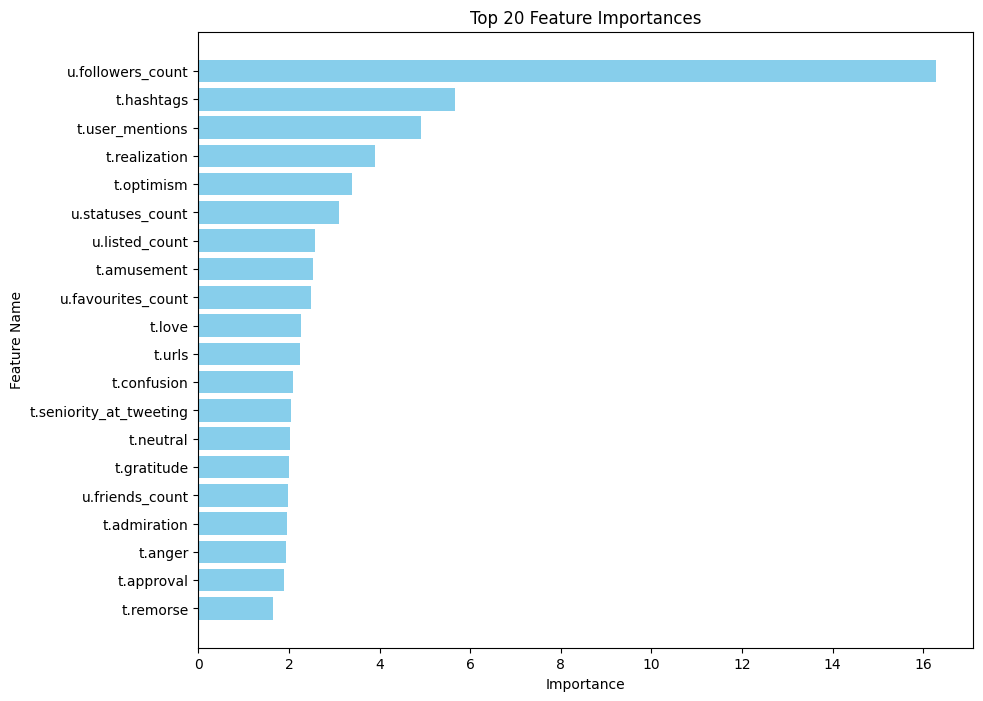

In [4]:
# Best model features importance plot
import matplotlib.pyplot as plt

# Load the best CatBoost model
model_cat_u_best_loaded = CatBoostClassifier()
model_cat_u_best_loaded.load_model("models/catboost_t_tm_new.cbm")

# Define feature names (ensure X_test has the columns defined)
feature_names = X_test_us_t.columns

# Retrieve and sort feature importance
feature_importance = model_cat_u_best_loaded.get_feature_importance()
feature_importance_map = dict(zip(feature_names, feature_importance))
sorted_importance = sorted(feature_importance_map.items(), key=lambda x: x[1], reverse=True)

# Select only the top 20 features
top_20_importance = sorted_importance[:20]
features, importances = zip(*top_20_importance)

# Create the bar chart for top 20 features
plt.figure(figsize=(10, 8))
plt.barh(features, importances, color='skyblue')  # Horizontal bar chart

# Add labels and title
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.title('Top 20 Feature Importances')

# Invert y-axis to have the most important feature on top
plt.gca().invert_yaxis()

# Display the plot
plt.show()